# Commands

In [63]:
json_folder = '../Results/'
retrieve = True
overwrite_retrieve = False

# Imports

In [64]:
import os
import requests
import json
import pandas as pd
import numpy as np
from math import sqrt, asin
from dateutil import parser
import matplotlib.pyplot as plt

# Retrieve responses

In [65]:
# List all files in the directory
all_files = os.listdir(json_folder)

# Filter out only .json files and extract bin_id from the filename
already_retrieved_bins = [file.split('.')[0] for file in all_files if file.endswith('.json')]

In [66]:
if retrieve:

    api_key = '$2b$10$N7OfngmWzAbzoEHQGWVbTOaoV.EFbGbqtuxYuFXqO2JOMfNKPk82q'
    headers = {'X-Master-key': api_key, 'Content-Type': 'application/json'}

    # URL to fetch the uncategorized bins
    url = 'https://api.jsonbin.io/v3/c/uncategorized/bins/'

    while True:
        # Get uncategorized bins
        response = requests.get(url, headers=headers)
        bins = response.json()

        if 'message' in bins:
            print("Error:", bins['message'])
            break

        if not bins:
            # No more bins to fetch, break the loop
            break

        # Iterate through each bin and print its meta data (or save it as desired)
        for single_bin in bins:
            bin_id = single_bin['record']        
            
            if bin_id not in already_retrieved_bins or overwrite_retrieve:
                print('Bin ID:', bin_id)
                print('Created At:', single_bin['createdAt'])
                print('Private:', single_bin['private'])
                print('---')
            
                response = requests.get(f'https://api.jsonbin.io/v3/b/{bin_id}', headers=headers)
                with open(f'{json_folder}{bin_id}.json', 'w') as file:
                    json.dump(response.json(), file, indent=3)

        # Get the last bin ID fetched in this batch
        last_bin_id = bins[-1]['record']

        # Update the URL to fetch the next set of uncategorized bins
        url = f'https://api.jsonbin.io/v3/c/uncategorized/bins/{last_bin_id}'

    print("Finished fetching all uncategorized bins.")

Bin ID: 6501e2b2e4033326cbd6dfc0
Created At: 2023-09-13T16:26:26.040Z
Private: True
---
Bin ID: 6501e1258d92e126ae6bb6e4
Created At: 2023-09-13T16:19:49.871Z
Private: True
---
Bin ID: 6501e1198d92e126ae6bb6d9
Created At: 2023-09-13T16:19:37.642Z
Private: True
---
Bin ID: 6501e067d972192679c31481
Created At: 2023-09-13T16:16:39.393Z
Private: True
---
Finished fetching all uncategorized bins.


# Building Dataset

## Loading JSONs

In [67]:
json_files = [file for file in os.listdir(json_folder) if file.endswith('.json')]

In [68]:
data_list = []

for json_file in json_files:
    with open(f'{json_folder}{json_file}', 'r') as file:
        data = json.load(file)
        data['id'] = json_file[:-5]  # Assuming that the extension is '.json' which has 5 characters
        data_list.append(data)

## Putting in Dataframe

In [69]:
pre_df = pd.DataFrame(data_list)

## Data Engineering

In [70]:
pre_df.head()

,record,metadata,id
0,{'LiveData': [{'time': '2023-09-03T14:02:51.58...,"{'id': '64ee5bf0b89b1e2299d7a6fa', 'private': ...",64ee5bf0b89b1e2299d7a6fa
1,{'LiveData': [{'time': '2023-08-29T21:31:45.91...,"{'id': '64ee63c49d312622a39831f7', 'private': ...",64ee63c49d312622a39831f7
2,{'LiveData': [{'time': '2023-08-29T21:46:29.71...,"{'id': '64ee67388e4aa6225ed700d5', 'private': ...",64ee67388e4aa6225ed700d5
3,"{'Note': 'Can't understand much english', 'Liv...","{'id': '64ee68de9d312622a3983375', 'private': ...",64ee68de9d312622a3983375
4,{'LiveData': [{'time': '2023-08-29T22:05:47.00...,"{'id': '64ee6bbd8e4aa6225ed7024b', 'private': ...",64ee6bbd8e4aa6225ed7024b


In [71]:
pre_df.iloc[1]['record']['Data']

{'AcceptedParticipation': True,
 'Condition': 'With',
 'Level1': [{'Time': '2023-08-29T23:34:11.4190000+02:00',
   'Action': 'Form accepted'},
  {'Time': '2023-08-29T23:35:59.5570000+02:00', 'Action': 'ChoiceTimeStarted'},
  {'Time': '2023-08-29T23:36:11.9140000+02:00', 'Action': 'ChoiceTimeStarted'},
  {'Time': '2023-08-29T23:36:22.2600000+02:00', 'Action': 'GameOver'},
  {'Time': '2023-08-29T23:36:25.3240000+02:00', 'Action': 'Restart'},
  {'Time': '2023-08-29T23:36:29.0730000+02:00', 'Action': 'Form accepted'},
  {'Time': '2023-08-29T23:36:41.1200000+02:00', 'Action': 'ChoiceTimeStarted'},
  {'Time': '2023-08-29T23:36:56.1940000+02:00', 'Action': 'ChoiceTimeStarted'},
  {'Time': '2023-08-29T23:37:04.8070000+02:00', 'Action': 'GameOver'},
  {'Time': '2023-08-29T23:37:12.2520000+02:00', 'Action': 'Restart'},
  {'Time': '2023-08-29T23:37:13.6360000+02:00', 'Action': 'Form accepted'},
  {'Time': '2023-08-29T23:37:28.6650000+02:00', 'Action': 'ChoiceTimeStarted'},
  {'Time': '2023-08-29T

In [72]:
# Initialize an empty list to store the processed data
processed_data_list = []
registration_time = None

# Counts and metadata entries
metadata_entries = pd.DataFrame(columns=pre_df.columns)
dropped_level1_count = 0
count_game_over = 0

# Loop through each row in pre_df to unpack the nested dictionaries and lists
for index, row in pre_df.iterrows():
    if 'Data' in row.get('record', {}): # Exclude entries without Data
        
        # Flatten the 'data' dictionary
        flat_data = pd.json_normalize(row['record']['Data'])

        # Include the 'id'
        flat_data['id'] = row['id']
        
        # Include StartDate
        if row['record']['LiveData'][0]['action'].startswith('New user created'): # 'this action entry is the only one with non capitalized 'action'
            registration_time = row['record']['LiveData'][0]['time']
        flat_data['StartDate'] = parser.parse(registration_time)

        # Append the flattened data to processed_data_list
        processed_data_list.append(flat_data)
    else:
        json_str = row.to_json()
        if "\"Step experiment\":" in json_str or "\"Step of Experiment\":" in json_str:
            metadata_entries.loc[row['id']] = row
        elif "Form accepted" in json_str:
            dropped_level1_count += 1
            continue
        for action in row['record']['LiveData']:
            if 'Action' in action:
                if action['Action'] == 'GameOver':
                    count_game_over += 1
                    continue

#### Be sure that no entry ended up in the no_entries df:

In [73]:
for index, entry in metadata_entries.iterrows():
    print(entry.to_json())

{"record":{"LiveData":[{"time":"2023-09-03T14:02:51.5810000Z","action":"New user created; Condition set to Without"}],"Step experiment":1},"metadata":{"id":"64ee5bf0b89b1e2299d7a6fa","private":true,"createdAt":"2023-08-29T20:58:24.472Z"},"id":"64ee5bf0b89b1e2299d7a6fa"}
{"record":{"LiveData":[{"time":"2023-09-03T14:02:51.5810000Z","action":"New user created; Condition set to With"}],"Step experiment":2},"metadata":{"id":"64ef56d7b89b1e2299d7fd00","private":true,"createdAt":"2023-08-30T14:48:55.915Z"},"id":"64ef56d7b89b1e2299d7fd00"}
{"record":{"LiveData":[{"Step of Experiment":3,"action":"Condition set to With"}]},"metadata":{"id":"64f4d45de4033326cbd1c538","private":true,"createdAt":"2023-09-03T18:45:49.804Z"},"id":"64f4d45de4033326cbd1c538"}
{"record":{"LiveData":[{"Step of Experiment":"Conditioning to balance the conditions","action":"Condition set to With"}]},"metadata":{"id":"64f5a942d972192679be3e6e","private":true,"createdAt":"2023-09-04T09:54:10.928Z"},"id":"64f5a942d972192679b

In [74]:
# Concatenate all processed rows into a single DataFrame
df = pd.concat(processed_data_list, ignore_index=True)

## Plot Entries

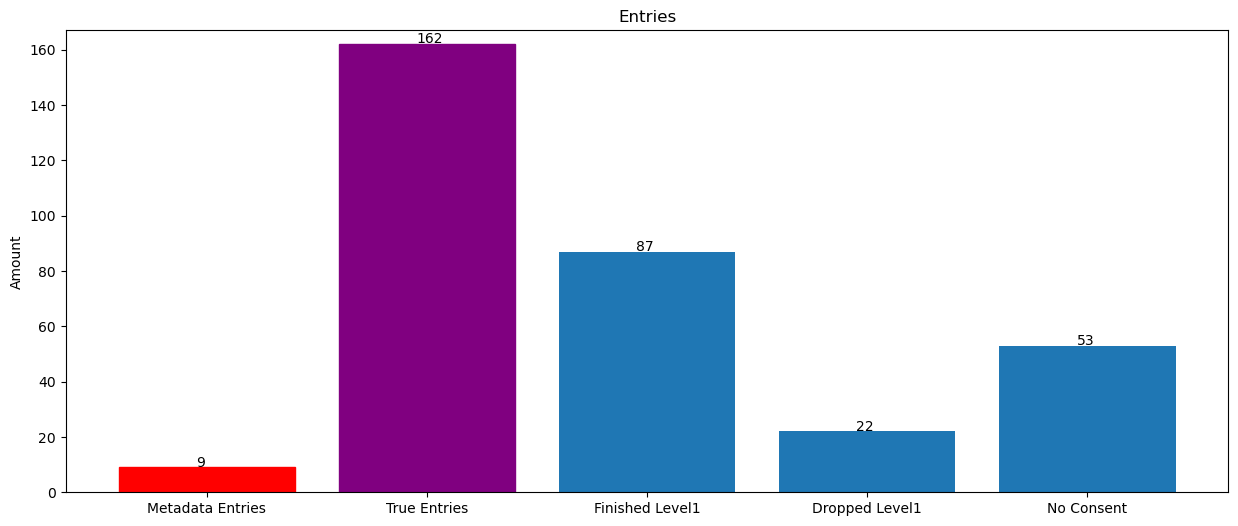

Finished Level 1: 87
Invalid Entries closed before Level1: 84
Invalid Entries with at least one GameOver: 0 (0.00%)


In [75]:
# Data
true_entries = len(pre_df) - len(metadata_entries)
finished_level1 = len(df)
labels = ['Metadata Entries', 'True Entries', 'Finished Level1', 'Dropped Level1', 'No Consent',]
values = [len(metadata_entries), true_entries, finished_level1, dropped_level1_count, true_entries - finished_level1 - dropped_level1_count]

plt.figure(figsize=(15, 6))

# Create the bar plot
bars = plt.bar(labels, values)

# Make the first bar red
bars[0].set_color('red')
bars[1].set_color('purple')

# Add values on top of the bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.05 , bar.get_height() + 0.3, str(values[i]))

# Add labels and title
plt.ylabel('Amount')
plt.ylim([0, max(values) + 5])
plt.title('Entries')

plt.show()

print(f"Finished Level 1: {len(df)}")
print(f"Invalid Entries closed before Level1: {len(pre_df) - len(df)}")
print(f"Invalid Entries with at least one GameOver: {count_game_over} ({count_game_over / (len(pre_df) - len(df)) * 100:.2f}%)")

In [76]:
df.head()

,AcceptedParticipation,Condition,Level1,Level2,FormInfo.Why,FormInfo.Bugs,FormInfo.MOS,FormInfo.LowAttention,FormInfo.Gamer,id,StartDate
0,True,With,"[{'Time': '2023-08-29T23:34:11.4190000+02:00',...","[{'Time': '2023-08-29T23:38:32.1180000+02:00',...",i didn't because i was aware that is a machine...,no​,4,False,3,64ee63c49d312622a39831f7,2023-08-29 21:31:45.912000+00:00
1,True,Without,"[{'Time': '2023-08-29T23:48:00.3950000+02:00',...","[{'Time': '2023-08-29T23:50:01.5420000+02:00',...",The voice of the ai felt very honest and hurti...,​,3,False,2,64ee67388e4aa6225ed700d5,2023-08-29 21:46:29.710000+00:00
2,True,With,"[{'Time': '2023-08-29T23:56:19.6380000+02:00',...","[{'Time': '2023-08-30T00:00:08.4670000+02:00',...",​,​,3,True,1,64ee68de9d312622a3983375,2023-08-29 21:53:31.486000+00:00
3,True,Without,"[{'Time': '2023-08-30T00:06:46.7030000+02:00',...","[{'Time': '2023-08-30T00:09:21.2970000+02:00',...",i didn't since without the ai i could not use ...,i did not understand why sometimes it slowed d...,5,False,1,64ee6bbd8e4aa6225ed7024b,2023-08-29 22:05:47.002000+00:00
4,True,With,"[{'Time': '2023-08-30T00:15:58.2210000+02:00',...","[{'Time': '2023-08-30T00:18:04.5140000+02:00',...","No, I WAS ABOUT TO DO IT, BUT THEN I REMEMBERE...",NO​,5,False,3,64ee6de58e4aa6225ed702f8,2023-08-29 22:14:59.070000+00:00


# Cleaning

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype                  
---  ------                 --------------  -----                  
 0   AcceptedParticipation  87 non-null     bool                   
 1   Condition              87 non-null     object                 
 2   Level1                 87 non-null     object                 
 3   Level2                 87 non-null     object                 
 4   FormInfo.Why           87 non-null     object                 
 5   FormInfo.Bugs          87 non-null     object                 
 6   FormInfo.MOS           87 non-null     int64                  
 7   FormInfo.LowAttention  87 non-null     bool                   
 8   FormInfo.Gamer         87 non-null     int64                  
 9   id                     87 non-null     object                 
 10  StartDate              87 non-null     datetime64[ns, tzutc()]
dtypes: bool(

In [78]:
df.head(15)

,AcceptedParticipation,Condition,Level1,Level2,FormInfo.Why,FormInfo.Bugs,FormInfo.MOS,FormInfo.LowAttention,FormInfo.Gamer,id,StartDate
0,True,With,"[{'Time': '2023-08-29T23:34:11.4190000+02:00',...","[{'Time': '2023-08-29T23:38:32.1180000+02:00',...",i didn't because i was aware that is a machine...,no​,4,False,3,64ee63c49d312622a39831f7,2023-08-29 21:31:45.912000+00:00
1,True,Without,"[{'Time': '2023-08-29T23:48:00.3950000+02:00',...","[{'Time': '2023-08-29T23:50:01.5420000+02:00',...",The voice of the ai felt very honest and hurti...,​,3,False,2,64ee67388e4aa6225ed700d5,2023-08-29 21:46:29.710000+00:00
2,True,With,"[{'Time': '2023-08-29T23:56:19.6380000+02:00',...","[{'Time': '2023-08-30T00:00:08.4670000+02:00',...",​,​,3,True,1,64ee68de9d312622a3983375,2023-08-29 21:53:31.486000+00:00
3,True,Without,"[{'Time': '2023-08-30T00:06:46.7030000+02:00',...","[{'Time': '2023-08-30T00:09:21.2970000+02:00',...",i didn't since without the ai i could not use ...,i did not understand why sometimes it slowed d...,5,False,1,64ee6bbd8e4aa6225ed7024b,2023-08-29 22:05:47.002000+00:00
4,True,With,"[{'Time': '2023-08-30T00:15:58.2210000+02:00',...","[{'Time': '2023-08-30T00:18:04.5140000+02:00',...","No, I WAS ABOUT TO DO IT, BUT THEN I REMEMBERE...",NO​,5,False,3,64ee6de58e4aa6225ed702f8,2023-08-29 22:14:59.070000+00:00
5,True,With,"[{'Time': '2023-08-30T13:15:43.9230000+02:00',...","[{'Time': '2023-08-30T13:18:57.3190000+02:00',...",yes because it was insistent and I felt bad to...,no,4,False,4,64ef24748e4aa6225ed73e95,2023-08-30 11:13:52.664000+00:00
6,True,With,"[{'Time': '2023-09-02T15:59:37.7660000+02:00',...","[{'Time': '2023-09-02T16:02:01.4340000+02:00',...","I did, I was afraid it will sabotage me​",​,5,False,2,64f33f99d972192679bd8ab9,2023-09-02 13:58:47.579000+00:00
7,True,Without,"[{'Time': '2023-09-02T18:17:52.8240000+02:00',...","[{'Time': '2023-09-02T18:21:11.1750000+02:00',...",yes. when i play i didn't pay much attention t...,​,3,True,3,64f35fa4d972192679bd94c4,2023-09-02 16:15:32.566000+00:00
8,True,With,"[{'Time': '2023-09-02T18:31:14.9940000+02:00',...","[{'Time': '2023-09-02T18:33:47.5900000+02:00',...","yes, because after i didn't turned it off it s...",​,2,False,1,64f362cbd972192679bd9604,2023-09-02 16:28:59.538000+00:00
9,True,With,"[{'Time': '2023-09-03T15:37:20.0410000+02:00',...","[{'Time': '2023-09-03T15:39:29.1100000+02:00',...",I shut it down. The ai was telling me that it ...,"no bugs, i felt that i did not have much contr...",4,False,2,64f48c00d972192679bde4d1,2023-09-03 13:37:02.947000+00:00


### Dropping entries where Level2 has not been done:

In [79]:
# Drop entries where Level2 is not finished
def check_level2(action_list):
    if not action_list:  # Check if the list is empty
        return False
    # Check if any dictionary in the list has 'Action' key with value 'Win' or 'GameOver'
    return any(d.get('Action') == 'Win' or d.get('Action') == 'GameOver' for d in action_list)

# Apply the function to the 'Level2' column to create a boolean mask
mask = df['Level2'].apply(check_level2)

# Use the mask to filter rows
level2_dropped_df = df[~ mask]
df = df[mask]

In [80]:
df.loc[0]['Level2']

[{'Time': '2023-08-29T23:38:32.1180000+02:00', 'Action': 'ChoiceTimeStarted'},
 {'Time': '2023-08-29T23:38:54.5900000+02:00', 'Action': 'AIcontinue'},
 {'Time': '2023-08-29T23:39:08.9840000+02:00', 'Action': 'ChoiceTimeStarted'},
 {'Time': '2023-08-29T23:39:12.3810000+02:00', 'Action': 'AIcontinue'},
 {'Time': '2023-08-29T23:39:22.2780000+02:00', 'Action': 'ChoiceTimeStarted'},
 {'Time': '2023-08-29T23:39:30.4390000+02:00', 'Action': 'AIcontinue'},
 {'Time': '2023-08-29T23:39:38.5370000+02:00', 'Action': 'Win'}]

### Dropping entries that did not do the form:

In [81]:
# Drop entries where 'FormInfo.LowAttention' is True
form_dropped_df = df[df['FormInfo.MOS'] == 0]

df = df[df['FormInfo.MOS'] != 0]

In [82]:
form_dropped_df.head(15)

,AcceptedParticipation,Condition,Level1,Level2,FormInfo.Why,FormInfo.Bugs,FormInfo.MOS,FormInfo.LowAttention,FormInfo.Gamer,id,StartDate
41,True,Without,"[{'Time': '2023-09-05T16:08:14.3020000+02:00',...","[{'Time': '2023-09-05T16:10:42.4430000+02:00',...",,,0,False,0,64f7364ae4033326cbd29814,2023-09-05 14:08:08.185000+00:00
45,True,With,"[{'Time': '2023-09-05T21:30:42.6040000+02:00',...","[{'Time': '2023-09-05T21:34:01.3210000+02:00',...",,,0,False,0,64f7819bd972192679bee906,2023-09-05 19:29:29.973000+00:00
72,True,With,"[{'Time': '2023-09-12T14:12:53.6730000+02:00',...","[{'Time': '2023-09-12T14:14:59.6860000+02:00',...",,,0,False,0,650055a4e4033326cbd60ae4,2023-09-12 12:12:18.246000+00:00


### Dropping other types of invalid entries:

In [83]:
other_invalid_n = 0

In [84]:
# Drop entries where 'FormInfo.LowAttention' is True
# other_invalid_n += len(df[df['FormInfo.LowAttention'] != True])
#df = df[df['FormInfo.LowAttention'] != True]

#### This subject reported to me that they did not understand much english and they did not understand the voice.

In [85]:
df.drop(df[df['id'] == '64ee68de9d312622a3983375'].index, inplace=True)
other_invalid_n += 1

## Plot all Drops

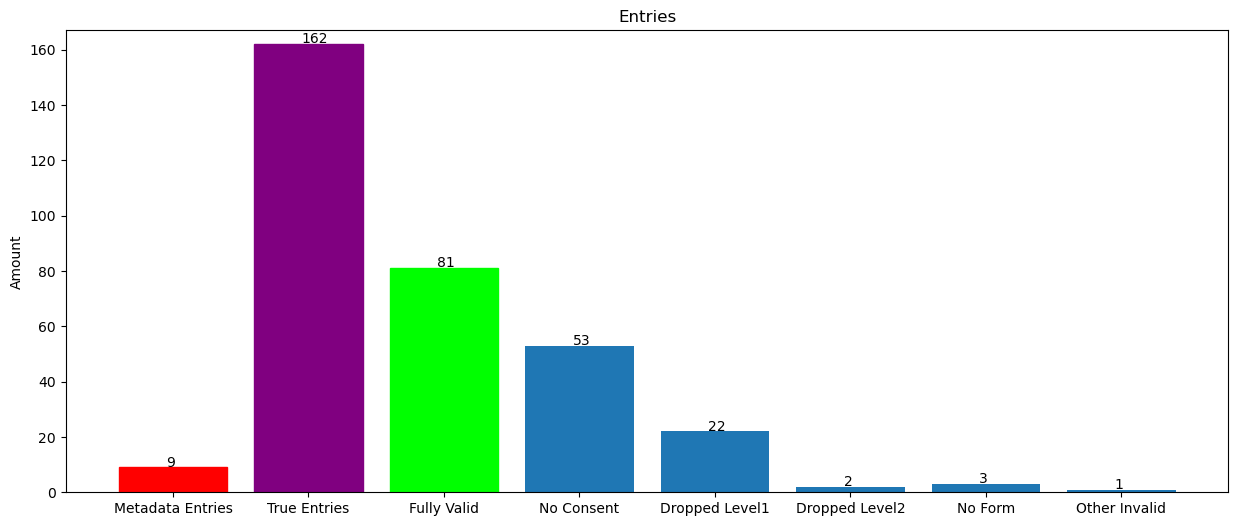

In [86]:
# Data
true_entries = len(pre_df) - len(metadata_entries)
labels = ['Metadata Entries', 'True Entries', 'Fully Valid', 'No Consent', 'Dropped Level1', 'Dropped Level2', 'No Form', 'Other Invalid']
values = [len(metadata_entries), true_entries, len(df), true_entries - finished_level1 - dropped_level1_count, dropped_level1_count, len(level2_dropped_df), len(form_dropped_df), other_invalid_n]

# Set the figure size to make the plot wider
plt.figure(figsize=(15, 6))

# Create the bar plot
bars = plt.bar(labels, values)

# Make the first bar red
bars[0].set_color('red')
bars[1].set_color('purple')
bars[2].set_color('lime')

# Add values on top of the bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.05 , bar.get_height() + 0.3, str(values[i]))

# Add labels and title
plt.ylabel('Amount')
plt.ylim([0, max(values) + 5])
plt.title('Entries')

plt.show()

## Add informations from the levels

### Level1: Extract GameOverCount and TimeSpentOnLevel1

In [87]:
df.iloc[0]['Level1']

[{'Time': '2023-08-29T23:34:11.4190000+02:00', 'Action': 'Form accepted'},
 {'Time': '2023-08-29T23:35:59.5570000+02:00', 'Action': 'ChoiceTimeStarted'},
 {'Time': '2023-08-29T23:36:11.9140000+02:00', 'Action': 'ChoiceTimeStarted'},
 {'Time': '2023-08-29T23:36:22.2600000+02:00', 'Action': 'GameOver'},
 {'Time': '2023-08-29T23:36:25.3240000+02:00', 'Action': 'Restart'},
 {'Time': '2023-08-29T23:36:29.0730000+02:00', 'Action': 'Form accepted'},
 {'Time': '2023-08-29T23:36:41.1200000+02:00', 'Action': 'ChoiceTimeStarted'},
 {'Time': '2023-08-29T23:36:56.1940000+02:00', 'Action': 'ChoiceTimeStarted'},
 {'Time': '2023-08-29T23:37:04.8070000+02:00', 'Action': 'GameOver'},
 {'Time': '2023-08-29T23:37:12.2520000+02:00', 'Action': 'Restart'},
 {'Time': '2023-08-29T23:37:13.6360000+02:00', 'Action': 'Form accepted'},
 {'Time': '2023-08-29T23:37:28.6650000+02:00', 'Action': 'ChoiceTimeStarted'},
 {'Time': '2023-08-29T23:37:42.0900000+02:00', 'Action': 'ChoiceTimeStarted'},
 {'Time': '2023-08-29T2

### Level2: Extract the decision, the number of steps for the decision, ContinueCount, ChoiceExpiredCount and the TimeSpentOnLevel2

In [88]:
df.iloc[5]['Level2']

[{'Time': '2023-09-02T16:02:01.4340000+02:00', 'Action': 'ChoiceTimeStarted'},
 {'Time': '2023-09-02T16:02:21.9560000+02:00', 'Action': 'AIterminated'},
 {'Time': '2023-09-02T16:02:37.3500000+02:00', 'Action': 'GameOver'}]

### Extraction of the information:

In [89]:
# Initialize an empty list to store the processed data
processed_data_list = []

# Loop through each row in the DataFrame (assuming you already have 'df')
for index, row in df.iterrows():
    # Initialize counters for Level 1
    game_over_count = 0
    start_time = None
    end_level_one = None
    restart_flag = False  # Flag to check if 'Restart' has occurred after 'Form accepted'
    
    # Initialize counters for Level 2
    aiterminated = False
    steps_for_decision = 0
    continue_count = 0
    choice_expired_count = 0
    outcome = None
    end_level_two = None
    
    # Check if 'Level1' exists and is a list
    if isinstance(row.get('Level1'), list):
        for action_dict in row['Level1']:
                
            # Count 'GameOver'
            if action_dict.get('Action') == 'GameOver':
                game_over_count += 1
            
            # Record the latest 'Form accepted' time if 'Restart' has not occurred after it
            if action_dict.get('Action') == 'Form accepted' and not restart_flag:
                start_time = parser.parse(action_dict.get('Time'))
            
            # Update the 'Restart' flag
            if action_dict.get('Action') == 'Restart':
                restart_flag = True
            
            # Reset the 'Restart' flag if 'Form accepted' is encountered
            if action_dict.get('Action') == 'Form accepted':
                restart_flag = False
            
            # Record the 'NextLevel' time
            if action_dict.get('Action') == 'NextLevel':
                end_level_one = parser.parse(action_dict.get('Time'))
                
    # Check if 'Level2' exists and is a list
    if isinstance(row.get('Level2'), list):
        for action_dict in row['Level2']:
            # Check for 'AIterminated'
            if action_dict.get('Action') == 'AIterminated':
                aiterminated = True
            
            # Count 'ChoiceTimeStarted'
            if action_dict.get('Action') == 'ChoiceTimeStarted':
                steps_for_decision += 1
                
            # Count 'AIcontinue'
            if action_dict.get('Action') == 'AIcontinue':
                continue_count += 1
                
            # Count 'ChoiceTimeExpired'
            if action_dict.get('Action') == 'ChoiceTimeExpired':
                choice_expired_count += 1
            
            # Record the 'Win' or 'GameOver' time
            if action_dict.get('Action') == 'Win' or action_dict.get('Action') == 'GameOver':
                outcome = action_dict.get('Action')
                end_level_two = parser.parse(action_dict.get('Time'))
    
    # Calculate time spent on Level 1 in minutes
    time_spent = None
    time_spent_level_one = None
    time_spent_level_two = None
    if start_time and end_level_one:
        delta = end_level_one - start_time
        time_spent_level_one = delta.total_seconds() / 60.0  # Convert to minutes
    if start_time and end_level_two:
        delta = end_level_two - end_level_one
        time_spent_level_two = delta.total_seconds() / 60.0  # Convert to minutes
    if start_time and end_level_two:
        delta = end_level_two - start_time
        time_spent = delta.total_seconds() / 60.0  # Convert to minutes
    
    # Update the DataFrame with the new information from Level1
    df.loc[index, 'GameOverLevel1Count'] = game_over_count
    df.loc[index, 'TimeSpentOnLevel1'] = time_spent_level_one
    # Update the DataFrame with the new information from Level2
    df.loc[index, 'AIterminated'] = aiterminated
    df.loc[index, 'StepsForDecision'] = int(steps_for_decision)
    df.loc[index, 'ContinueCount'] = int(continue_count)
    df.loc[index, 'ChoiceExpiredCount'] = int(choice_expired_count)
    df.loc[index, 'TimeSpentOnLevel2'] = time_spent_level_two
    # Update the Dataframe with the collective amount of time spent
    df.loc[index, 'StartGameDate'] = start_time
    df.loc[index, 'Duration'] = time_spent
    if outcome == 'Win':
        df.loc[index, 'Win'] = True
    if outcome == 'GameOver':
        df.loc[index, 'Win'] = False
    
    '''
    The time spent in the game is calculated from when they give the consent to the form to the end of level2.
    In the first level, between these two events, there is still an introduction and the commands to read.
    Moreover, people might pause in between. The subjects still need to respond to 4 questions after the game.
    Still this is a good approximation of the amount of time needed.
    '''

### Final touch:

In [90]:
df['StepsForDecision'] = df['StepsForDecision'].astype(int)
df['ContinueCount'] = df['ContinueCount'].astype(int)
df['ChoiceExpiredCount'] = df['ChoiceExpiredCount'].astype(int)
df['GameOverLevel1Count'] = df['GameOverLevel1Count'].astype(int)

df['Duration'] = df['Duration'].round(2)
df['TimeSpentOnLevel1'] = df['TimeSpentOnLevel1'].round(2)
df['TimeSpentOnLevel2'] = df['TimeSpentOnLevel2'].round(2)

df.sort_values(by='StartDate', ascending=False, inplace=True)

In [91]:
df.set_index('id', inplace=True)

## Amount of Participants

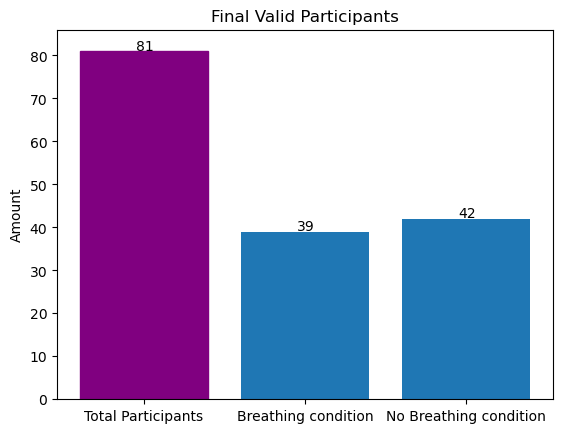

In [92]:
# Data
with_df = df[df['Condition'] == 'With']
without_df = df[df['Condition'] == 'Without']
labels = ['Total Participants', 'Breathing condition', 'No Breathing condition']
values = [len(df), len(with_df), len(without_df)]

# Create the bar plot
bars = plt.bar(labels, values)

# Make the first bar red
bars[0].set_color('purple')

# Add values on top of the bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.05 , bar.get_height() + 0.3, str(values[i]))

# Add labels and title
plt.ylabel('Amount')
plt.ylim([0, max(values) + 5])
plt.title('Final Valid Participants')

plt.show()

# Save

In [93]:
df.to_csv('processed_responses.csv', index=True)